# Edge Classification with Graph Neural Networks

In this notebook, we design and train a Graph Neural Network for edge and node classifications.

We use the **clustering of EM showers** and the **identification of shower primaries** in precision imaging detectors as a test case. EM showers typically manifest themselves as a set of disjoint energy deposition islands that have no dense connectivity, which makes them difficult to cluster, particularly in a busy environment. The image below shows two showers in a Liquid Argon Time Projection Chamber:

![](https://www.researchgate.net/profile/Dorota_Stefan/publication/242233583/figure/fig1/AS:298551822307331@1448191709790/Electromagnetic-showers-in-the-Liquid-Argon-TPC-initiated-by-electron-upper-part-and-p_Q640.jpg)

We use a dataset of simulated EM shower in liquid argon and build our own training and test set out of it:
- Nodes are **shower fragments**, i.e. dense clusters of energy depositions associated with an EM particle
- Edges are **potential connections** between those shower fragments that form shower objects (share a common primary)

In this example:
- Node scores are interpreted as the likelihood of a node being a primary
- Edge scores are interpreted as the likelihood of two nodes belonging to the same group.

For more detail about the implementation discussed here, please check out this [paper](https://arxiv.org/abs/2007.01335).

## Goals

- Load an HDF5 file, build a torch Dataset using Torch Geometric's Data structure
- Design a message passing Graph Neural Network for node and edge predictions
- Train the edge prediction network, study its performance

## 1. Take a look at the dataset

The HDF5 datasets used in this notebook consist of three components:
- `voxels`: a variable-length array of `(N, 6)` tensors of 3D shower voxels `(x, y, z, frag_id, group_id, primary_bool)`
- `node_features`: a variable-length array of `(C, 19)` tensors of node features `(*node_features, frag_id, group_id, primary_bool)`
  - Fragment voxel centroid (3)
  - Fragment voxel covariance matrix (9)
  - Fragment voxel principal axis (3)
  - Number of voxels in the frament (1)
- `edge_features`: a variable-length array of `(E,22)` tensors of edge features `(*edge_features, frag_id_1, frag_id_2, on_bool)`
  - Closest points of approach (6)
  - Displacement vector between closest points of approach (3)
  - Outer product of displacement (9)
  - Norm of displacement (1)
  
![](node_features.png)![](edge_features.png)
  
For each image, the set of shower fragments corresponds to the set of nodes and every possible pairs of those nodes form an edge, so that there are `E = C*(C-1)` edges for `C` nodes (graph is **complete** and **undirectred**).
  
They have been stored in two HDF5 files which can be opened and accessed as a dictionary:
- `particle_shower_gnn_train.h5`: a file to train the network
- `particle_shower_gnn_test.h5`:  a file to test the network

### Shower fragment labels

First, let's access a single event `voxels` and draw the input fragments and target groups using `Plotly`

Cycle through the different shower fragment labels by clicking on the legen

In [3]:
import copy
import h5py # python hdf5 file library
import plotly.graph_objects as go # Plotly graph objects
from plotly.offline import iplot  # Interactive plots
import plotly.express as px # For discrete color scale

# Load the file, get the voxels of the first event
event_id = 2
with h5py.File('particle_shower_gnn_train.h5', "r") as f:
    voxels = f['voxels'][event_id].reshape(-1,6)
    
# Initialize a fragment graph, draw
graph = go.Scatter3d(x = voxels[:,0],
                     y = voxels[:,1],
                     z = voxels[:,2],
                     name = 'Fragments',
                     mode = 'markers', 
                     marker = dict(
                         size = 2, 
                         color = voxels[:,3], # List of voxel fragment ids
                         colorscale = px.colors.qualitative.Dark24)
                    )

# Duplicate the fragment graph, relabel the voxels with the target groups ids
graph_target = copy.copy(graph)
graph_target['name'] = 'Groups'
graph_target['marker']['color'] = voxels[:,4] # List of voxel group ids

# Duplicate the fragment graph, relabel the voxels with the target primary ids
graph_primary = copy.copy(graph)
graph_primary['name'] = 'Primaries'
graph_primary['marker']['color'] = voxels[:,5] # List of voxel primary ids

iplot([graph_primary, graph_target, graph])

### Edge index

Now, we take a look at the graph edges. In this study, the graph is **complete**, which means that every node is connected with every other node in the graph.  It is also **undirected**, which means that if a path exists from i to j, it exists from j to i.

The way the edge IDs are stored is by specifying the ID of the indices of the two nodes it connects together: [i,j].

To represent graphs, we use the `networkx` package that we've use before:

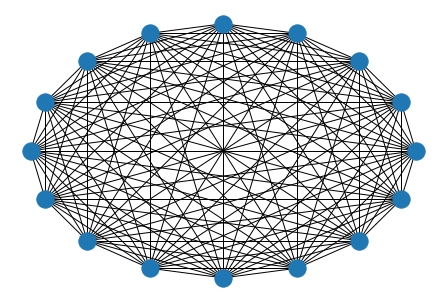

In [9]:
import numpy as np
import networkx as nx

# Get the edge data, slice the columns corresponding to the edge IDs
with h5py.File('particle_shower_gnn_train.h5', "r") as f:
    data = f['edge_features'][event_id].reshape(-1,22)
    
edge_index = data[:,-3:-1].astype(int)

# Initialize a graph, add the edges
G = nx.Graph()
G.add_edges_from(edge_index)
nx.draw_kamada_kawai(G) # Kamada-Kawai structures the graph in a symmetric way here

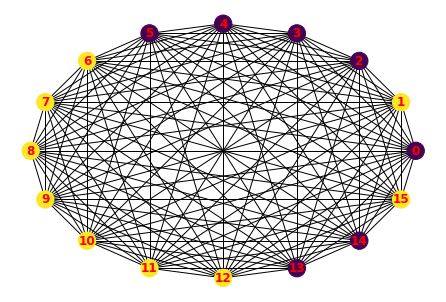

In [10]:
# Now specify the group ID of the nodes in the graph
nx.draw_kamada_kawai(G, node_color=group_ids, with_labels=True, font_color='red', font_weight='bold')

### Edge labels

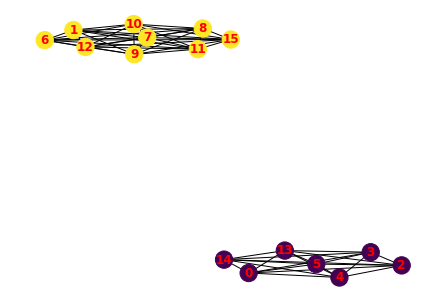

In [11]:
# Now remove the edges that should not be predicted by the network
edge_labels = data[:,-1].astype(int)
true_edges = edge_index[edge_labels.astype(bool)]
G_label = nx.Graph()
G_label.add_nodes_from(np.arange(len(group_ids)))
G_label.add_edges_from(true_edges)
nx.draw(G_label, node_color=group_ids, with_labels=True, font_color='red', font_weight='bold')

## 2. Build a Dataset and a DataLoader

### Dataset

In order to use this dataset to train and test a Graph Neural Network, it is necessary to create a `PyG` `Dataset` to define how to access an entry and to minimize the time spent on I/O by the algorithm.

In our case, we want the `Dataset` to return an object which contains:
- List of node features, i.e. the shower fragments features
- List of edges, i.e. list of *directed* pairs of node indices for each edge
- List of edge features
- List of node labels, i.e. the group that each node belongs to
- Index of the event being accessed

In the next cell, we define the `ShowerDataset` class which provides a method to build `PyG` `Data` objects, from the HDF5 files, for a given event ID:

In [59]:
import h5py
import numpy as np
import torch
from torch_geometric.data import Dataset
from torch_geometric.data import Data

class ShowerDataset(Dataset):
    """
    class: an interface for shower fragment data files. This Dataset is designed to produce a batch of
           of node and edge feature data.
    """
    def __init__(self, file_path):
        """
        Args: file_path ..... path to the HDF5 file that contains the feature data
        """
        # Load file, store pointer to the node and edge features datasets
        data_file = h5py.File(file_path, "r")
        self._node_data = data_file['node_features']
        self._edge_data = data_file['edge_features']

        # Check the number of entries
        self._entries = len(self._node_data)


    def __len__(self):
        
        return self._entries

    def __getitem__(self, idx):
            
        # Get the subset of node and edge features that correspond to the requested event ID
        node_info = torch.tensor(self._node_data[idx].reshape(-1, 19), dtype=torch.float32)
        node_features, group_ids, node_labels = node_info[:,:-3], node_info[:,-2].long(), node_info[:,-1].long()
        
        edge_info = torch.tensor(self._edge_data[idx].reshape(-1, 22), dtype=torch.float32)
        edge_features, edge_index, edge_labels = edge_info[:,:-3], edge_info[:,-3:-1].long().t(), edge_info[:,-1].long()
        
        return Data(x = node_features,
                    edge_index = edge_index,
                    edge_attr = edge_features,
                    y = node_labels,
                    edge_label = edge_labels,
                    index = idx)

In [60]:
dataset = ShowerDataset('particle_shower_gnn_train.h5')
print('Number of events in dataset:', len(dataset))
dataset[0]

Number of events in dataset: 44047


Data(edge_attr=[1406, 19], edge_index=[2, 1406], edge_label=[1406], index=0, x=[38, 16], y=[38])

The returned `Data` object contains all the necessary tensors to train the network:
- `x` for node features
- `edge_index` for the list of edges (in the `(2,E)` form)
- `edge_attr` for the edge features
- `y` for the node labels
- `index` for the event index

### DataLoader

Now, use the built-in `DataLoader` provided by `PyG` to define a way to produce batches of the `PyG` `Data` objects:

In [61]:
from torch_geometric.data import DataLoader

loader = DataLoader(dataset = dataset,
                    shuffle = True,
                    batch_size = 32,
                    num_workers = 1,
                    pin_memory = False)

In [62]:
it = iter(loader)
data = next(it)
data

Batch(batch=[568], edge_attr=[11232, 19], edge_index=[2, 11232], edge_label=[11232], index=[32], x=[568, 16], y=[568])

In [63]:
np.unique(data.batch, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([22, 17, 24, 16, 15,  9,  6, 25, 17, 11, 10, 16, 36, 19, 23, 13, 12,
        15, 20, 31, 21,  7, 13, 13, 14,  7, 19, 32, 17, 27, 26, 15]))

What the batch merge of `Pytorch Geometric` does is the following:
- It adds a new `batch` object which is an array batch ids for each of the node (length `C`)
- It stacks the `x`, `edge_features`, `y` and `index` into single tensors
- It stacks the `edge_index`, relabling the edges coming from different batches to insure that no edge connects two nodes from different entries

This process allows for faster computation than to run the Graph Neural Network on individual entries.

## 3. Graph Neural Network Architecture

There are two basic functions that this Graph Neural Network should perform:
1. Update the edge features by aggregating the features of connected nodes
2. Update the node features by aggregating the features of connected edges and neighboring nodes

In this example, we use the `MetaLayer` from `PyG`, which is the one of the most general implementation of message passing, as presented in the lecture and extensively discussed in this [paper](https://arxiv.org/pdf/1806.01261.pdf).

### Edge updater

The first step is to design a function that takes the edge features and nodes features of the two adjacent nodes and aggregates them using a neural network. In this case, we choose to use an MLP with two hidden layers (see previous lectures):
- The input is a tensor of dimension `(E, N_e + 2*N_c)` with `E` the number of edges, `N_e` the number of edge features and `N_c` the number of node features (it aggreates edge features with the two adjacent node features)
- At each layer the features are batch normalized (see previous lectures) and constrained to `N_e'` number of new edge features (here `N_e' = 64`)

In [64]:
import torch.nn as nn # Neural Network implementations in PyTorch

class EdgeLayer(nn.Module):
    def __init__(self, node_in, edge_in, edge_out, leakiness=0.0):
        super(EdgeLayer, self).__init__()
        self.edge_mlp = nn.Sequential(
            nn.BatchNorm1d(2 * node_in + edge_in),
            nn.Linear(2 * node_in + edge_in, edge_out),
            nn.LeakyReLU(negative_slope=leakiness),
            nn.BatchNorm1d(edge_out),
            nn.Linear(edge_out, edge_out),
            nn.LeakyReLU(negative_slope=leakiness),
            nn.BatchNorm1d(edge_out),
            nn.Linear(edge_out, edge_out)
        )

    def forward(self, src, dest, edge_attr, u=None, batch=None):
        out = torch.cat([src, dest, edge_attr], dim=1)
        return self.edge_mlp(out)

### Node updater
The second step is to design a function that takes the node features and the features coming from all the adjacent and edges and neighbouring node and aggregate them to update the node features. This time, we break down the node update into two separate steps, each consisting of MLPs
- The first one aggregates the source node features with their connecting edge features `(E, N_e'+N_c)` and passes them through an MLP. This step forms a set of **messages** `(E,N_m)` (here `N_m = 64`), i.e. features that will be passed to the node being updated
- The second one updates the target node features by concatenating the target nodes features with the **mean message** `(C,N_c+N_c')` coming from its neighborhood and passing it through an MLP to form new node features `(C, N_c')` (here `N_c' = 64`).

The only subtlety here is the `scatter_mean` function which is simply an efficient way of computing the mean message, given a certain index of messages to be aggregated for each node

![](https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true)

In [65]:
import torch.nn as nn # Neural Network implementations in PyTorch
from torch_scatter import scatter_mean # Fast computation of node group mean features

class NodeLayer(nn.Module):
    def __init__(self, node_in, node_out, edge_in, leakiness=0.0):
        super(NodeLayer, self).__init__()

        self.node_mlp_1 = nn.Sequential(
            nn.BatchNorm1d(node_in + edge_in),
            nn.Linear(node_in + edge_in, node_out),
            nn.LeakyReLU(negative_slope=leakiness),
            nn.BatchNorm1d(node_out),
            nn.Linear(node_out, node_out),
            nn.LeakyReLU(negative_slope=leakiness),
            nn.BatchNorm1d(node_out),
            nn.Linear(node_out, node_out)
        )

        self.node_mlp_2 = nn.Sequential(
            nn.BatchNorm1d(node_in + node_out),
            nn.Linear(node_in + node_out, node_out),
            nn.LeakyReLU(negative_slope=leakiness),
            nn.BatchNorm1d(node_out),
            nn.Linear(node_out, node_out),
            nn.LeakyReLU(negative_slope=leakiness),
            nn.BatchNorm1d(node_out),
            nn.Linear(node_out, node_out)
        )

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1) # Aggregating neighboring node with connecting edges
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0)) # Building mean messages
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

### Full model

Now, we need to combine the two into a single GNN model to be used to classify node and edges.

Here we specify the following parameters:
- `node_input`: the number of node features (16)
- `edge_input`: the number of edge features (19)
- `node_output`: the size of the node embedding space (64)
- `edge_output`: the size of the edge output embedding space (64)
- `leakiness`: the leakiness of LeakyReLU layers, i.e their slope for negative values (0.1)
- `num_mp`: the number of times node and edge embeddings are updated

The way the `MetaLayer` at each message pasing spet is initialized is by providing it with a method for edge and node updates, in our case `EdgeLayer` and `NodeLayer`, as we have defined previously. This can technically be any learnable function. 

After all the message passing steps, the node and edge embeddings are contracted to 2 each, to represent:
- The score for `[secondary, primary]` for nodes
- The score for `[off, on]` for edges

In [66]:
import torch.nn as nn # Neural Network implementations in PyTorch
from torch_geometric.nn import MetaLayer

class GNNModel(nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()

        # Initialize the updaters
        self.message_passing = torch.nn.ModuleList()

        # Update the node and edge feature N times (number of message passings, here = 3)
        node_input  = 16 # Number of input node features
        edge_input  = 19 # Number of input edge features
        node_output = 64  # Number of intermediate node features
        edge_output = 64  # Number of intermediate edge features
        leakiness = 0.1 # LeakyRELU activation leakiness
        self.num_mp = 3 # Number of message passings
        
        for i in range(self.num_mp):
            self.message_passing.append(
                MetaLayer(
                    edge_model = EdgeLayer(node_input, edge_input, edge_output, leakiness=leakiness),
                    node_model = NodeLayer(node_input, node_output, edge_output, leakiness=leakiness)
                )
            )
            node_input = node_output
            edge_input = edge_output

        
        # Reduce the number of node and edge features edge, as we are performing a simple classification
        self.node_predictor = nn.Linear(node_output, 2)
        self.edge_predictor = nn.Linear(edge_output, 2)

    def forward(self, data):

        # Loop over message passing steps, pass data through the updaters
        x = data.x
        e = data.edge_attr
        for i in range(self.num_mp):
            x, e, _ = self.message_passing[i](x, data.edge_index, e, batch=data.batch)
            
        # Reduce output features to 2 each
        x_pred = self.node_predictor(x)
        e_pred = self.edge_predictor(e)

        # Return
        res = {
            'node_pred': x_pred,
            'edge_pred': e_pred
            }

        return res

In [67]:
model = GNNModel()
model

GNNModel(
  (message_passing): ModuleList(
    (0): MetaLayer(
        edge_model=EdgeLayer(
      (edge_mlp): Sequential(
        (0): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=51, out_features=64, bias=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): LeakyReLU(negative_slope=0.1)
        (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): Linear(in_features=64, out_features=64, bias=True)
      )
    ),
        node_model=NodeLayer(
      (node_mlp_1): Sequential(
        (0): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=80, out_features=64, bias=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): BatchNorm1d(64, eps=1e-05, mom

In [68]:
output = model(data)
output.keys(), output['node_pred'].shape, output['edge_pred'].shape

(dict_keys(['node_pred', 'edge_pred']),
 torch.Size([568, 2]),
 torch.Size([11232, 2]))

# 4. Train the network

In this section, we define the target of the minimization task and the loss function constructed to achieve it. We then go through how to run the optimization.

### Loss Function
Here the goal is to define the **loss function**, which expresses how far the predictions of the network are from the ground-truth. The ground-truth here is two-fold:
1. If an edge connects two nodes belonging to the same group, it should be given a score of 1, and 0 otherwise
2. If a node is a primary, i.e. it corresponds to the first energy deposition, it should be given a score of 1, 0 otherwise

The loss function used here is a simple cross-entropy loss, as covered in previous lectures. What this loss expresses is that, if the score predicted is close to the ground-truth, the loss is close to 0.

![](https://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png)

In [69]:
lossfn = torch.nn.CrossEntropyLoss(reduction='mean') # Mean cross-entropy loss

node_loss = lossfn(output['node_pred'], data.y) # Primary identification loss
edge_loss = lossfn(output['edge_pred'], data.edge_label) # Edge classification loss

node_loss, edge_loss

(tensor(0.7209, grad_fn=<NllLossBackward>),
 tensor(0.6969, grad_fn=<NllLossBackward>))

### Train loop

Here we define a function which 
1. loops over the data
2. passes each bach through the model
3. computes the loss
4. Optimize the weights at each step

In [130]:
def train_gnn(loader, model, num_iterations=100, lr=0.001, optimizer='Adam', gpu=False):
    
    # Create an optimizer
    optimizer = getattr(torch.optim,optimizer)(model.parameters(),lr=lr)
    
    # Now we run the training, and keep track of the loss values
    losses, edge_losses, node_losses = [], [], []
    while num_iterations > 0:
        for data in loader:
            # Bring data to GPU, if requested
            if gpu:
                data = data.cuda()

            # Prediction
            prediction = model(data)
            
            # Compute loss
            node_loss = lossfn(prediction['node_pred'], data.y) # Primary identification loss
            edge_loss = lossfn(prediction['edge_pred'], data.edge_label) # Edge classification loss

            loss = node_loss + edge_loss
            
            # Update model weights
            optimizer.zero_grad() # Clear gradients from previous steps
            loss.backward()       # Compute the derivative of the loss w.r.t. the model parameters using backprop
            optimizer.step()      # Steps the model weights according to the lr and gradients
            
            # Record loss
            losses.append(loss.item())
            node_losses.append(node_loss.item())
            edge_losses.append(edge_loss.item())
            
            # Break if over the requested number of iterations
            num_iterations -= 1
            if num_iterations < 1:
                break
        
    return np.array(losses), np.array(node_losses), np.array(edge_losses)

### Train 

Now run 1000 iterations of the training set (64000 randomly sampled events in 1000 batches of size 64, a bit above an epoch).

In [131]:
dataset = ShowerDataset('particle_shower_gnn_train.h5')

loader = DataLoader(dataset = dataset,
                    shuffle = True,
                    batch_size = 64,
                    num_workers = 1,
                    pin_memory = False)

In [133]:
model = GNNModel()

%time losses, node_losses, edge_losses = train_gnn(loader, model, num_iterations=1000, gpu=False)

CPU times: user 1h 8min 11s, sys: 14.2 s, total: 1h 8min 26s
Wall time: 11min 14s


Check out the loss functions!

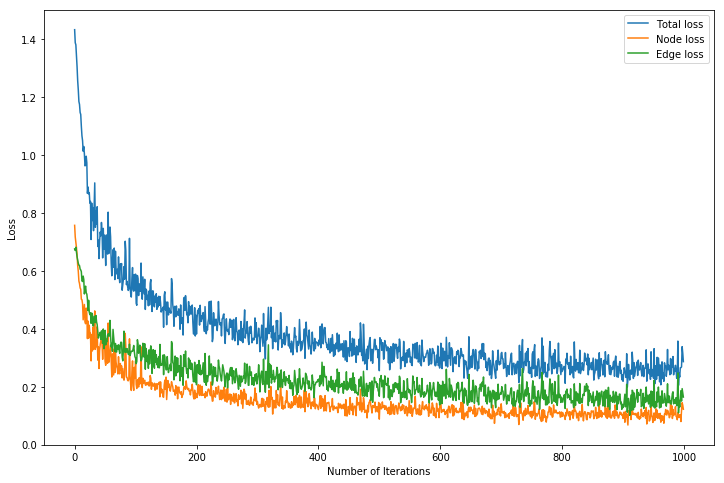

In [135]:
from matplotlib import pyplot as plt

plt.figure(figsize = (12,8))
plt.plot(losses, label='Total loss')
plt.plot(node_losses, label='Node loss')
plt.plot(edge_losses, label='Edge loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.draw()

### Exercise 1

As in the first nodebook, output the node embeddings from the GNN model just before the classifier layer and represent them using t-SNE before and after training the network

In [154]:
# Your code here

# 5. Inference

Use the trained network to make predictions.

### Binary classification accuracy

The first thing we look at is how often the nodes and edges are classified correctly.

Let's first define the test Dataloader, which is identical to the train dataloader but reads the test HDF5 file.

In [136]:
dataset = ShowerDataset('particle_shower_gnn_test.h5')

loader = DataLoader(dataset = dataset,
                    shuffle = False,
                    batch_size = 64,
                    num_workers = 1,
                    pin_memory = False)

Then, let's define a function, similar to the training function, but which records the predictions for all the node and edges along with their two-channel scores.

In [137]:
def test_gnn_scores(model,loader,gpu=False):

    from scipy.special import softmax

    node_event_v, edge_event_v     = [], [] # Stores the event ID of each node/edge
    node_pred_v, edge_pred_v       = [], [] # Stores the binary prediction for node and edges (argmax)
    node_softmax_v, edge_softmax_v = [], [] # Stores the softmax score for the primary and ON channel of node and edges, respectively
    node_label_v, edge_label_v     = [], [] # Stores the true binary label for node and edges
    edge_index_v = [] # Stores the edge index for each event
    
    with torch.set_grad_enabled(False):
        idx = 0
        for data in loader:
            if gpu:
                data = data.cuda()
            prediction = model(data)
            
            node_pred, edge_pred = prediction['node_pred'].cpu().numpy(), prediction['edge_pred'].cpu().numpy()
            
            node_event_v.append(data.index[data.batch].numpy())
            edge_event_v.append(data.index[data.batch[data.edge_index[0]]].numpy())
            
            node_pred_v.append( np.argmax(node_pred, axis=1)    )
            edge_pred_v.append( np.argmax(edge_pred, axis=1)    )
            
            node_softmax_v.append( softmax(node_pred, axis=1)[:,1] )
            edge_softmax_v.append( softmax(edge_pred, axis=1)[:,1] )
            
            node_label_v.append( data.y )
            edge_label_v.append( data.edge_label )
            
            cids = np.concatenate([np.arange(c) for c in np.unique(data.batch.numpy(),return_counts=True)[1]])
            edge_index_v.append( cids[data.edge_index.numpy()].T )
            
            idx +=1
            
    return np.concatenate(node_event_v), np.concatenate(edge_event_v),\
           np.concatenate(node_pred_v), np.concatenate(edge_pred_v),\
           np.concatenate(node_softmax_v), np.concatenate(edge_softmax_v),\
           np.concatenate(node_label_v), np.concatenate(edge_label_v),\
           np.vstack(edge_index_v)

In [138]:
%time node_event, edge_event, node_pred, edge_pred, \
      node_softmax, edge_softmax, node_label, edge_label, edge_indices = test_gnn_scores(model, loader)

CPU times: user 2min 37s, sys: 932 ms, total: 2min 38s
Wall time: 26.7 s


### Node classification scores

Check out the score distributions for true secondaries and true primaries:

Secondary classification accuracy: 0.9732206375554727
Primary classification accuracy: 0.9082896207756471


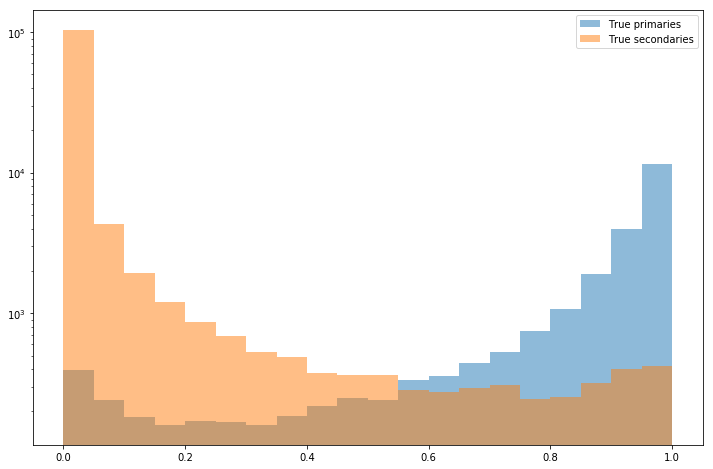

In [141]:
# Draw the softmax score of nodes
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
plt.hist(node_softmax[node_label==1], bins=20, range=[0,1.0001], label='True primaries', alpha=0.5)
plt.hist(node_softmax[node_label==0], bins=20, range=[0,1.0001], label='True secondaries', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.draw()

secondary_mask, primary_mask = node_label==0, node_label==1
print('Secondary classification accuracy:', np.sum(node_label[secondary_mask]==node_pred[secondary_mask])/np.sum(secondary_mask))
print('Primary classification accuracy:', np.sum(node_label[primary_mask]==node_pred[primary_mask])/np.sum(primary_mask))

### Exercise 2

Balance classes in the node loss, i.e. give larger weight to the loss associated with the less represented class. 

Compare the node classification results with the same training regiment.

In [142]:
# Your code here

### Edge classification scores

Check out the score distributions for true OFF edges and true ON edges:

OFF edge classification accuracy: 0.9385034682569894
ON edge classification accuracy: 0.938489885111451


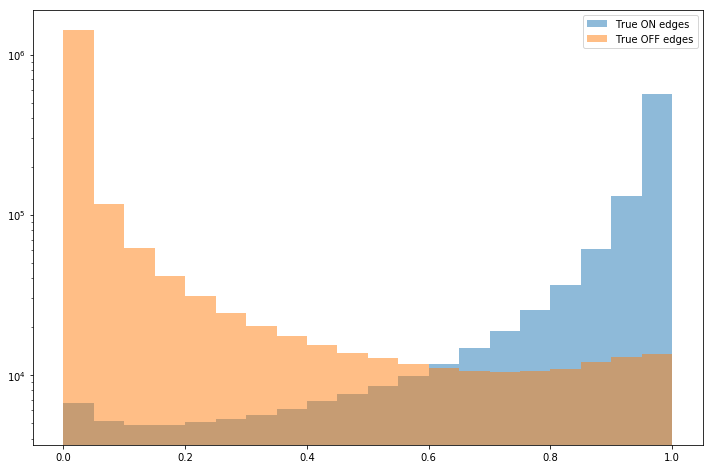

In [169]:
# Draw the softmax score of edges
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
plt.hist(edge_softmax[edge_label==1], bins=20, range=[0,1.0001], label='True ON edges', alpha=0.5)
plt.hist(edge_softmax[edge_label==0], bins=20, range=[0,1.0001], label='True OFF edges', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.draw()

off_mask, on_mask = edge_label==0, edge_label==1
print('OFF edge classification accuracy:', np.sum(edge_label[off_mask]==edge_pred[off_mask])/np.sum(off_mask))
print('ON edge classification accuracy:', np.sum(edge_label[on_mask]==edge_pred[on_mask])/np.sum(on_mask))

### Fragment clustering with Union-Find

Now we would like to interpret the edge predictions as node clustering predictions instead.

How is that done ? Here's the most trivial approach:
- The first observation is that if an edge is given a score > 0.5, it shows that the network believes that the two nodes the edge connects together belong to the same group (this is what the network is trying to learn!)
- Given that premise, it is natural to simply consider that if any edge connecting a node A and a node B has a score > 0.5, those nodes should be placed in the same group. This is essentially the [Union-Find algorithm](https://www.geeksforgeeks.org/union-find/), which iteratively puts nodes together if a path is found between them, i.e. identifies connected components.

Union-Find is implemented in the `network_utils`

In [ ]:
from network_utils import union_find

Now let's take a simple example to check what this algorithm does.

Let's take a set of 8 nodes that are such:
- Edges that connect any of [0,1,2,3] are given a score of 0.9
- Edges that connect any of [4,5,6,7] are given a score of 0.9
- All other edges are given a score of 0.1

If we threshold edge scores to be > 0.5, only the following edges are on:

In [230]:
import numpy as np
edges = np.array([[0, 0, 0, 1, 1, 2, 4, 4, 4, 5, 5, 6], 
                  [1, 2, 3, 2, 3, 3, 5, 6, 7, 6, 7, 7]]).T

Let's draw the corresponding graph:

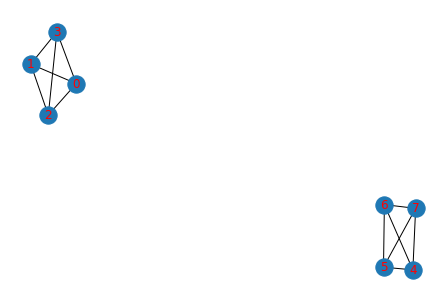

In [231]:
import numpy as np
import networkx as nx
G = nx.Graph()

nodes = np.arange(8)
node_labels = [0,0,0,1,1,1]

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True, font_color='red', font_style='bold')

Now let's form the clusters:

In [233]:
group_ids, groups = union_find(edges, len(nodes))
groups, group_ids

({0: {0, 1, 2, 3}, 4: {4, 5, 6, 7}}, array([0, 0, 0, 0, 4, 4, 4, 4]))

And finally, draw the cluster labels:

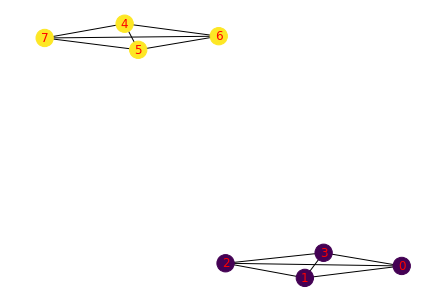

In [235]:
nx.draw(G, node_color=group_ids, with_labels=True, font_color='red', font_style='bold')

### Fragment clustering accuracy

Now we'd like to understand how well we can reproduce the true fragment clustering. Let's start with a single event: 
- Get the edge predictions
- Get the node groups with union find
- Characterize the clustering accuracy

In [236]:
# Form a edge mask for the desired event
event_id = 0
event_mask = edge_event == event_id
edge_index = edge_indices[event_mask]
pred = edge_pred[event_mask]
label = edge_label[event_mask]

# Run Union-Find to form node clusters
n_clusts = len(np.unique(edge_index))
true_group_ids, _ = union_find(edge_index[label == 1], n_clusts)
group_ids, _ = union_find(edge_index[pred == 1], n_clusts)

print('True group labels:', true_group_ids)
print('Predicted group labels:', group_ids)

True group labels: [0 0 0 0 4 5 6 7 7 5 5 4 4 4]
Predicted group labels: [0 0 0 0 4 5 5 7 7 5 5 4 4 4]


Now represent the clusters corresponding to this event 

In [237]:
import copy
import h5py # python hdf5 file library
import plotly.graph_objects as go # Plotly graph objects
from plotly.offline import iplot  # Interactive plots
import plotly.express as px # For discrete color scale

# Load the file, get the voxels of the first event
event_id = 0
with h5py.File('particle_shower_gnn_test.h5', "r") as f:
    voxels = f['voxels'][event_id].reshape(-1,6)
    
clust_ids = np.unique(voxels[:,-3], return_inverse=True)[1]

    
# Initialize a prediction graph, draw
graph = go.Scatter3d(x = voxels[:,0],
                     y = voxels[:,1],
                     z = voxels[:,2],
                     name = 'Prediction',
                     mode = 'markers', 
                     marker = dict(
                         size = 2, 
                         color = group_ids[clust_ids], # List of predicted voxel group ids
                         colorscale = px.colors.qualitative.Dark24)
                    )

# Duplicate the prediction graph, relabel the voxels with the true groups ids
graph_target = copy.copy(graph)
graph_target['name'] = 'Label'
graph_target['marker']['color'] = true_group_ids[clust_ids] # List of voxel group ids

iplot([graph, graph_target])

Assess the clustering accuracy y using two metrics:

- `Purity`: measure of overclustering, i.e. if two nodes that do not belong to the same cluster are put together, purity goe down
- `Efficiency`: measure of underclustering, i.e if two nodes that belong to the same cluster are broken by the algorithm, efficiency goes down

In [238]:
from notebook_utils import purity, efficiency

print('Clustering purity:', purity(true_group_ids, group_ids))
print('Clustering efficiency:', efficiency(true_group_ids, group_ids))

Clustering purity: 0.9375
Clustering efficiency: 1.0


### Exercise 3

Process all of the test set, evaluate the clustering accuracy by using purity and efficiency.

In [239]:
# Your code here

### Bonus: Is this the best we can do ?
Simply thresholding on edge scores has a glaring weekness. Picture this:

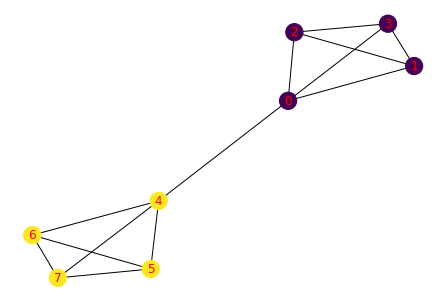

In [240]:
import numpy as np
import networkx as nx
G = nx.Graph()

nodes = np.arange(8)
node_labels = [0,0,0,1,1,1]
edges = np.array([[0, 0, 0, 0, 1, 1, 2, 4, 4, 4, 5, 5, 6], 
                  [1, 2, 3, 4, 2, 3, 3, 5, 6, 7, 6, 7, 7]]).T

G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, node_color=[0,0,0,0,1,1,1,1], with_labels=True, font_color='red', font_style='bold')

In this example:
- The node color represent the true group label
- The edges that have been given a score 0.9 by the network are drawn
- The edges that have been given a score 0.1 by the network are not drawn

Now, if one simply runs Union-Find, one will naturally put all nodes in the same group, because there is one connection between the two label groups through edge [0,4] which has been given a score of 0.9.

But is it really the best way to interpret these network predictions ? It isn't, and here's why:
1. What does the network try to minimize ? The edge Cross-Entropy loss
2. So, given a set of scores, one should pick the node partition that minimizes it! This is called partition score optimization.

In this example, let's compute the mean edge CE loss for a partition P = [0,0,0,0,0,0,0,0] where all nodes are put together. In this case, 13 edges correctly connect nodes that belong to the unique group, each only incrementing the loss by -ln(0.9). **However**, 8*7/2-13 = 15 edges have a score incompatible with a unique group and each increment the loss by -ln(0.1), for a total mean CE loss of

In [241]:
(-13*np.log(0.9) - 15*np.log(0.1))/28

1.2824451106593724

Now, let's compute the same loss but for a partition P' = [0,0,0,0,1,1,1,1] where nodes are put in the two correct groups. Now **all edges but one** actually reflect the true partition, yielding a mean CE loss of

In [242]:
(-27*np.log(0.9) - np.log(0.1))/28

0.1838328219912627

Which is a lot better! So clearly, given the same set of scores, there is a better partition than the one provided by Union-Find.

One problem remains... how does one **guess** the correct partition? 

We cheated in this example because we know the correct partition, but in reality we do not.

One way is the following:
1. Start with an empty graph, each node is its own group
2. Compute the score of the fully disjoint partition.
3. Add the next most likely edge to the graph, identify the new partition using Union-Find
4. Compute the new partition score. If it is strictly better than before, add the edge to the graph
5. Repeat 3 and 4 until the next available edge has a score < 0.5

This method builds a forest, i.e. a set of trees (no loops) and achieves a semi-opimal partition, without having to test all possible partitions (the brute force method is prohibitively slow due to the huge number of possible partitions: [Bell number](https://en.wikipedia.org/wiki/Bell_number))

In [243]:
from notebook_utils import node_assignment_score

scores = edge_softmax[event_mask]
scores = np.hstack(((1-scores).reshape(-1,1), scores.reshape(-1,1)))
score_group_ids = node_assignment_score(edge_index, scores, len(np.unique(edge_index)))

In [244]:
# Load the file, get the voxels of the first event
event_id = 0
with h5py.File('particle_shower_gnn_test.h5', "r") as f:
    voxels = f['voxels'][event_id].reshape(-1,6)
    
clust_ids = np.unique(voxels[:,-3], return_inverse=True)[1]

    
# Initialize a prediction graph, draw
graph = go.Scatter3d(x = voxels[:,0],
                     y = voxels[:,1],
                     z = voxels[:,2],
                     name = 'Score-based Prediction',
                     mode = 'markers', 
                     marker = dict(
                         size = 2, 
                         color = score_group_ids[clust_ids], # List of predicted voxel group ids
                         colorscale = px.colors.qualitative.Dark24)
                    )

# Duplicate the prediction graph, relabel the voxels with the true groups ids
graph_target = copy.copy(graph)
graph_target['name'] = 'Label'
graph_target['marker']['color'] = true_group_ids[clust_ids] # List of voxel group ids

iplot([graph, graph_target])

### Exercise 4

Use the implementation of partition score optimization below to see if it improves clustering accuracy

Spoiler alert: It does.

In [245]:
# Your code here